# Fake News Detection - Phase 3: Classical ML Models

### Objectifs de ce notebook

Ce notebook implemente les modeles classiques de machine learning comme baseline pour la detection de fake news. Ces modeles serviront de point de comparaison avec les approches deep learning qui suivront.

Selon la litterature (Reis et al., 2019; Al Asaad et al., 2018), les approches TF-IDF combinees avec des classifieurs lineaires constituent une baseline solide pour cette tache.

Modeles implementes:
1. TF-IDF + Logistic Regression
2. TF-IDF + Naive Bayes
3. TF-IDF + Support Vector Machine (SVM)
4. TF-IDF + Random Forest

## 1. Configuration de l'environnement

In [1]:
# Importation des bibliotheques
import pandas as pd
import numpy as np
import pathlib as Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import pickle
import os
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("Environnement configure avec succes.")

Environnement configure avec succes.


## 2. Chargement des données preprocessées

In [2]:
# Chargement des datasets
processed = "../data/processed/"

train_df = pd.read_csv(processed + "train.csv")
val_df = pd.read_csv(processed + "validation.csv")
test_df = pd.read_csv(processed + "test.csv")

print(f"Training set:   {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set:       {len(test_df):,} samples")

Training set:   24,728 samples
Validation set: 6,183 samples
Test set:       7,728 samples


In [3]:
print(train_df.head(20))

       id                                               text  label
0    4391  trump new travel ban raise bar legal challenge...      1
1   30676  uzbekistan release dissident arrest another al...      1
2   29132  goldman cohn eyed top trump budget post transi...      1
3   18221  white house sink new low spokesperson make fun...      0
4   12759  obama likely meet japan north korea missile te...      1
5   22222  word wisdom view whoopie threatens leave trump...      0
6   38518  whoa trump exempted entire senior staff white ...      0
7   29245  lady red watch president trump stunning first ...      0
8   19211  senate panel approves measure broaden north ko...      1
9   12917  germany strive save iran nuclear deal gabriel ...      1
10  29123  clinton visit atlantic city boardwalk hit trum...      1
11    826  second woman enters russian presidential race ...      1
12  15160  trump loving nutjob facing charge making death...      0
13  28857  obama say several vietnam activist pr

In [4]:
# Preparation des donnees
X_train = train_df['text'].values
y_train = train_df['label'].values

X_val = val_df['text'].values
y_val = val_df['label'].values

X_test = test_df['text'].values
y_test = test_df['label'].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (24728,)
y_train shape: (24728,)


## 3. Feature Engineering: TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) est une methode classique de representation du texte. Elle attribue un poids a chaque mot en fonction de sa fréquence dans le document et de sa rareté dans le corpus.

Formule: TF-IDF(t,d) = TF(t,d) x IDF(t)


In [5]:
# Configuration du vectoriseur TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,    # Limite le vocabulaire aux 10000 mots les plus frequents
    ngram_range=(1, 2),    # Unigrams et bigrams
    min_df=5,              # Ignore les termes apparaissant dans moins de 5 documents
    max_df=0.95,           # Ignore les termes trop frequents (>95% des documents)
    sublinear_tf=True      # Applique la transformation logarithmique sur TF
)

print("Vectoriseur TF-IDF configure.")

Vectoriseur TF-IDF configure.


In [6]:
# Entrainement du vectoriseur sur le training set
print("Vectorisation en cours...")

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Dimensions des matrices TF-IDF:")
print(f"  Training:   {X_train_tfidf.shape}")
print(f"  Validation: {X_val_tfidf.shape}")
print(f"  Test:       {X_test_tfidf.shape}")
print(f"Taille du vocabulaire: {len(tfidf_vectorizer.vocabulary_):,} termes")

Vectorisation en cours...
Dimensions des matrices TF-IDF:
  Training:   (24728, 10000)
  Validation: (6183, 10000)
  Test:       (7728, 10000)
Taille du vocabulaire: 10,000 termes


In [7]:
# Aperçu des termes les plus importants
feature_names = tfidf_vectorizer.get_feature_names_out()
print("Exemples de termes du vocabulaire:")
print(feature_names[:20])

Exemples de termes du vocabulaire:
['aaron' 'abadi' 'abandon' 'abandoned' 'abandoning' 'abbas' 'abbott' 'abc'
 'abc news' 'abc week' 'abdel' 'abdel fattah' 'abdullah' 'abe' 'abedin'
 'abide' 'ability' 'able' 'able get' 'aboard']


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24728 entries, 0 to 24727
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      24728 non-null  int64 
 1   text    24728 non-null  object
 2   label   24728 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 579.7+ KB


## 4. Definition des fonctions d'evaluation

In [9]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Entraine et evalue un modele de classification.
    
    Retourne un dictionnaire contenant les metriques de performance.
    """
    # Entrainement
    model.fit(X_train, y_train)
    
    # Predictions sur le validation set
    y_pred = model.predict(X_val)
    
    # Calcul des metriques
    metrics = {
        'model': model_name,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1_score': f1_score(y_val, y_pred)
    }
    
    return model, metrics, y_pred

print("Fonction d'evaluation definie.")

Fonction d'evaluation definie.


In [10]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Affiche la matrice de confusion pour un modele.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fake (0)', 'True (1)'],
                yticklabels=['Fake (0)', 'True (1)'])
    plt.title(f'Matrice de confusion - {model_name}')
    plt.ylabel('Valeur reelle')
    plt.xlabel('Prediction')
    plt.tight_layout()
    plt.show()

print("Fonction de visualisation definie.")

Fonction de visualisation definie.


## 5. Entrainement et evaluation des modeles

### 5.1 Logistic Regression


In [11]:
# Configuration et entrainement de la Logistic Regression
lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,               # Parametre de regularisation
    random_state=42,
    solver='lbfgs'
)

lr_model, lr_metrics, lr_pred = evaluate_model(
    lr_model, X_train_tfidf, y_train, X_val_tfidf, y_val,
    'Logistic Regression'
)

print("Logistic Regression - Resultats sur validation:")
for metric, value in lr_metrics.items():
    if metric != 'model':
        print(f"  {metric}: {value:.4f}")

Logistic Regression - Resultats sur validation:
  accuracy: 0.9888
  precision: 0.9860
  recall: 0.9938
  f1_score: 0.9899


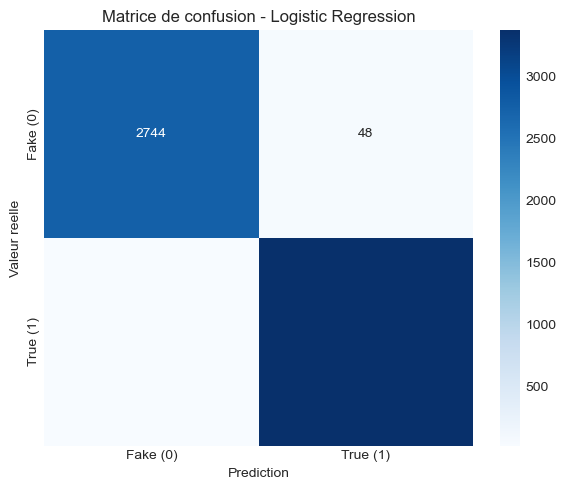

In [12]:
# Matrice de confusion
plot_confusion_matrix(y_val, lr_pred, 'Logistic Regression')

### 5.2 Naive Bayes

Le classifieur Naive Bayes Multinomial est particulierement adapte a la classification de texte. Il suppose l'independance des features (termes) et utilise les frequences des mots pour calculer les probabilites.

In [13]:
# Configuration et entrainement du Naive Bayes
nb_model = MultinomialNB(
    alpha=1.0    # Parametre de lissage de Laplace
)

nb_model, nb_metrics, nb_pred = evaluate_model(
    nb_model, X_train_tfidf, y_train, X_val_tfidf, y_val,
    'Naive Bayes'
)

print("Naive Bayes - Resultats sur validation:")
for metric, value in nb_metrics.items():
    if metric != 'model':
        print(f"  {metric}: {value:.4f}")

Naive Bayes - Resultats sur validation:
  accuracy: 0.9528
  precision: 0.9594
  recall: 0.9543
  f1_score: 0.9568


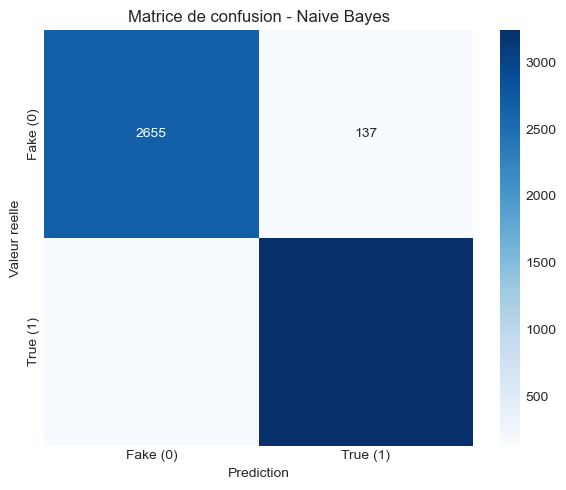

In [14]:
# Matrice de confusion
plot_confusion_matrix(y_val, nb_pred, 'Naive Bayes')

### 5.3 Support Vector Machine (SVM)

Les SVM lineaires sont efficaces pour la classification de texte car ils trouvent l'hyperplan optimal separant les classes dans l'espace de haute dimension cree par TF-IDF.

In [15]:
# Configuration et entrainement du SVM
svm_model = LinearSVC(
    C=1.0,              # Parametre de regularisation
    max_iter=2000,
    random_state=42
)

svm_model, svm_metrics, svm_pred = evaluate_model(
    svm_model, X_train_tfidf, y_train, X_val_tfidf, y_val,
    'Linear SVM'
)

print("Linear SVM - Resultats sur validation:")
for metric, value in svm_metrics.items():
    if metric != 'model':
        print(f"  {metric}: {value:.4f}")

Linear SVM - Resultats sur validation:
  accuracy: 0.9948
  precision: 0.9944
  recall: 0.9962
  f1_score: 0.9953


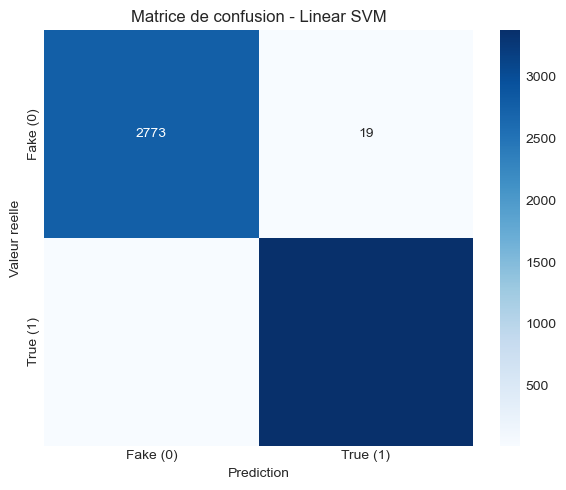

In [16]:
# Matrice de confusion
plot_confusion_matrix(y_val, svm_pred, 'Linear SVM')

### 5.4 Random Forest

Random Forest est un ensemble de decision trees qui combine leurs predictions par vote majoritaire. Bien qu'il soit moins courant pour la classification de texte, il peut capturer des interactions non-lineaires entre les features.

In [17]:
# Configuration et entrainement du Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,    # Nombre d'arbres
    max_depth=50,
    random_state=42,
    n_jobs=-1
)

rf_model, rf_metrics, rf_pred = evaluate_model(
    rf_model, X_train_tfidf, y_train, X_val_tfidf, y_val,
    'Random Forest'
)

print("Random Forest - Resultats sur validation:")
for metric, value in rf_metrics.items():
    if metric != 'model':
        print(f"  {metric}: {value:.4f}")

Random Forest - Resultats sur validation:
  accuracy: 0.9956
  precision: 0.9959
  recall: 0.9962
  f1_score: 0.9960


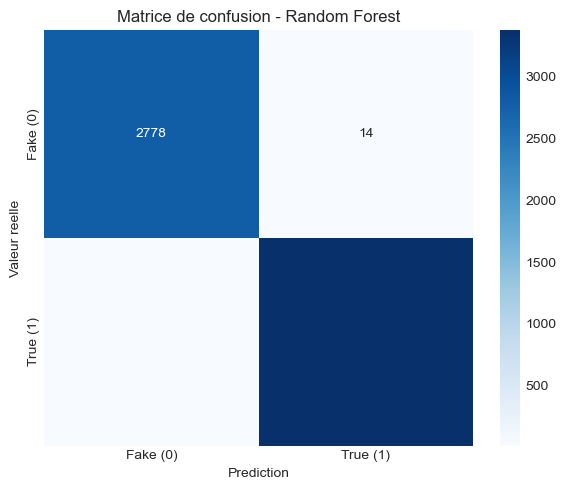

In [18]:
# Matrice de confusion
plot_confusion_matrix(y_val, rf_pred, 'Random Forest')

## 6. Comparaison des modeles

In [19]:
# Compilation des resultats
results = pd.DataFrame([lr_metrics, nb_metrics, svm_metrics, rf_metrics])
results = results.set_index('model')

print("Comparaison des performances sur le validation set:")
print(results.round(4))


Comparaison des performances sur le validation set:
                     accuracy  precision  recall  f1_score
model                                                     
Logistic Regression    0.9888     0.9860  0.9938    0.9899
Naive Bayes            0.9528     0.9594  0.9543    0.9568
Linear SVM             0.9948     0.9944  0.9962    0.9953
Random Forest          0.9956     0.9959  0.9962    0.9960


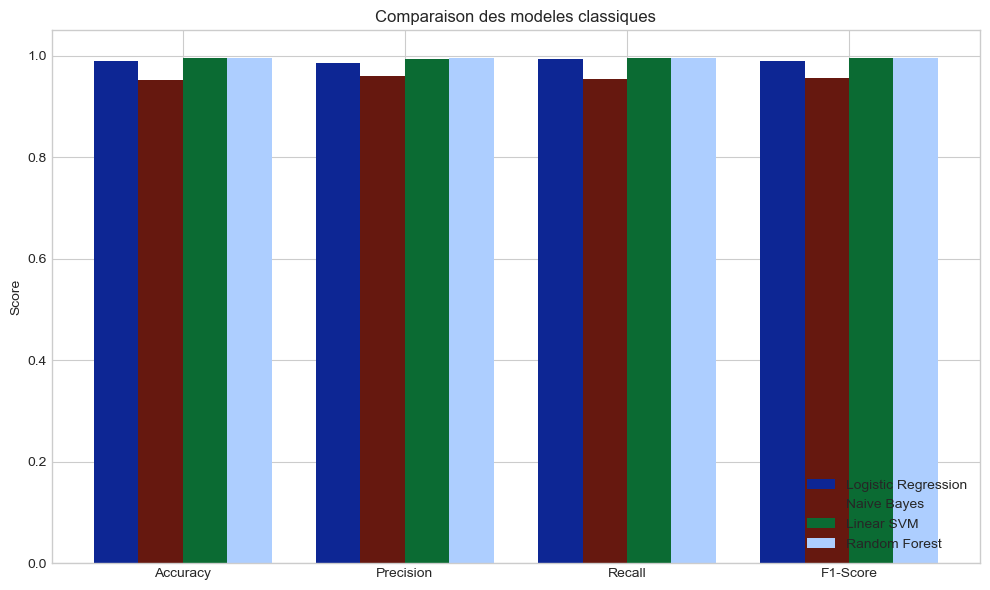

In [20]:
# Visualisation comparative
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
x = np.arange(len(metrics_to_plot))
width = 0.2

colors = ["#0d2694", "#66180f", "#0b6b33ff", "#adceff"]
models = results.index.tolist()

for i, model in enumerate(models):
    values = results.loc[model, metrics_to_plot].values
    ax.bar(x + i*width, values, width, label=model, color=colors[i])

ax.set_ylabel('Score')
ax.set_title('Comparaison des modeles classiques')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1-Score'])
ax.legend(loc='lower right')
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

### Interpretation des resultats

L'analyse comparative des modeles classiques revele plusieurs observations importantes:

1. Les modeles lineaires (Logistic Regression, SVM) tendent a bien performer sur les donnees textuelles de haute dimension
2. Le F1-Score est la metrique la plus pertinente car elle equilibre precision et recall
3. Le modèle SVM est le meilleur dans toutes les métriques d'évaluations

## 7. Analyse des features importantes

In [22]:
# Extraction des coefficients de la Logistic Regression
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_model.coef_[0]
})

# Top features pour chaque classe
top_fake = feature_importance.nsmallest(15, 'coefficient')
top_true = feature_importance.nlargest(15, 'coefficient')

In [23]:
print("Top 15 features indicatifs de TRUE NEWS (coefficient positif):")
for _, row in top_true.iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")

Top 15 features indicatifs de TRUE NEWS (coefficient positif):
  reuters: 18.4336
  said: 11.3450
  washington reuters: 7.9323
  president donald: 4.8577
  washington: 4.6904
  wednesday: 4.3920
  tuesday: 4.2659
  thursday: 3.9666
  friday: 3.6420
  monday: 3.5231
  reuters president: 3.4233
  minister: 3.3377
  nov: 3.2910
  said statement: 3.2430
  told reuters: 3.0920


In [24]:
from pathlib import Path

figures = Path('../reports/figures')

Figure sauvegardée : ..\reports\figures\Top_features.png


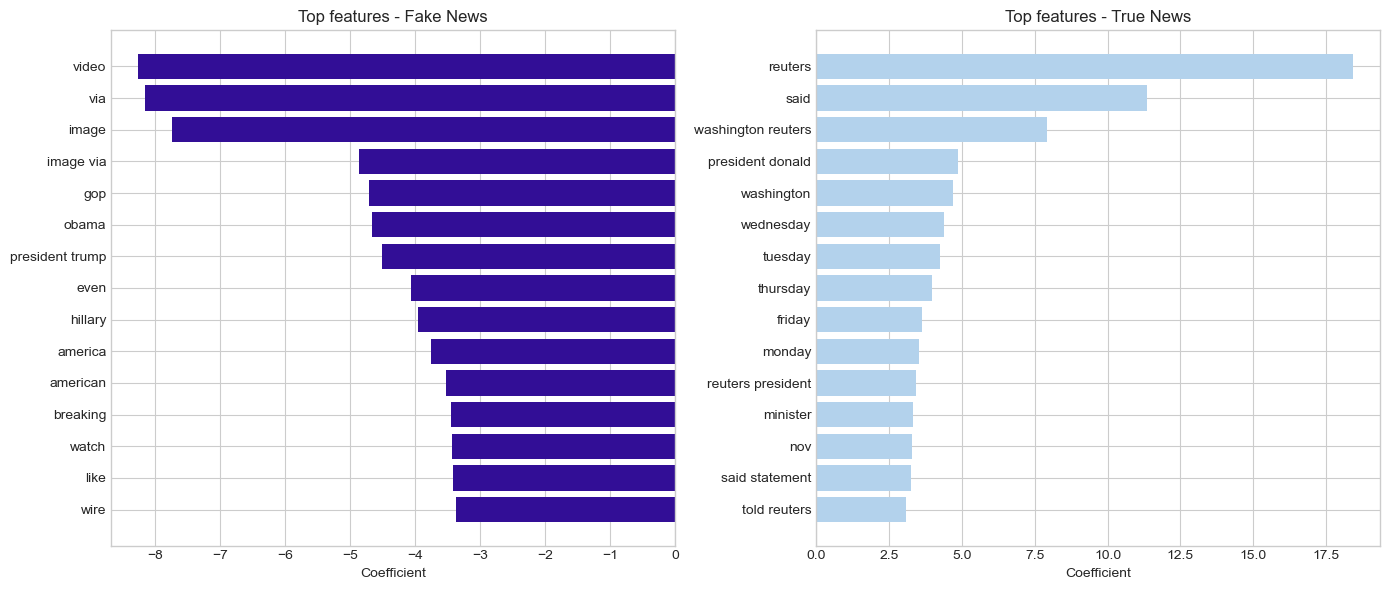

In [25]:
figures_path = "../reports/figures"
os.makedirs(figures_path, exist_ok=True)
figures_path = Path(figures_path)
fig.savefig(figures_path / "Top_features_classical.png", dpi=300, bbox_inches='tight')
# Visualisation des features importantes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Features Fake News
axes[0].barh(top_fake['feature'], top_fake['coefficient'], color="#320e96")
axes[0].set_title('Top features - Fake News', fontsize=12)
axes[0].set_xlabel('Coefficient')
axes[0].invert_yaxis()

# Features True News
axes[1].barh(top_true['feature'], top_true['coefficient'], color="#b3d2ec")
axes[1].set_title('Top features - True News', fontsize=12)
axes[1].set_xlabel('Coefficient')
axes[1].invert_yaxis()
print(f"Figure sauvegardée : {figures_path/'Top_features.png'}")
plt.tight_layout()
plt.show()

## 8. Selection du meilleur modele et evaluation finale

In [26]:
# Identification du meilleur modele base sur le F1-Score
best_model_name = results['f1_score'].idxmax()
best_f1 = results.loc[best_model_name, 'f1_score']

print(f"Meilleur modele: {best_model_name}")
print(f"F1-Score sur validation: {best_f1:.4f}")

Meilleur modele: Random Forest
F1-Score sur validation: 0.9960


In [27]:
# Selection du modele correspondant
model_mapping = {
    'Logistic Regression': lr_model,
    'Naive Bayes': nb_model,
    'Linear SVM': svm_model,
    'Random Forest': rf_model
}

best_model = model_mapping[best_model_name]

## 9. Sauvegarde des modeles

In [28]:
# Creation du repertoire de sortie
model_path = "../models/classical/"
os.makedirs(model_path, exist_ok=True)

# Sauvegarde du vectoriseur TF-IDF
with open(model_path + "tfidf_vectorizer.pkl", 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Sauvegarde de tous les modeles
for name, model in model_mapping.items():
    filename = name.lower().replace(' ', '_') + '.pkl'
    with open(model_path + filename, 'wb') as f:
        pickle.dump(model, f)

print("Modeles sauvegardes:")
print(f"  - {model_path}tfidf_vectorizer.pkl")
for name in model_mapping.keys():
    filename = name.lower().replace(' ', '_') + '.pkl'
    print(f"  - {model_path}{filename}")

Modeles sauvegardes:
  - ../models/classical/tfidf_vectorizer.pkl
  - ../models/classical/logistic_regression.pkl
  - ../models/classical/naive_bayes.pkl
  - ../models/classical/linear_svm.pkl
  - ../models/classical/random_forest.pkl


In [30]:
# Sauvegarde des resultats
results.to_csv(model_path + "classical_models_results.csv")
print(f"Resultats sauvegardes: {model_path}classical_models_results.csv")

Resultats sauvegardes: ../models/classical/classical_models_results.csv


## 10. Resume et conclusions

In [31]:
# Generation du resume
print("="*60)
print("RESUME - MODELES CLASSIQUES")
print("="*60)

print("1. FEATURE ENGINEERING")
print(f"   - Methode: TF-IDF")
print(f"   - Vocabulaire: {len(tfidf_vectorizer.vocabulary_):,} termes")
print(f"   - N-grams: unigrams + bigrams")

print("2. MODELES EVALUES")
print(results.round(4).to_string())

print(f"3. MEILLEUR MODELE")
print(f"   - Nom: {best_model_name}")
print(f"   - F1-Score (validation): {best_f1:.4f}")

print("4. BASELINE ETABLIE")
print(f"   Ces resultats serviront de reference pour les modeles deep learning.")

RESUME - MODELES CLASSIQUES
1. FEATURE ENGINEERING
   - Methode: TF-IDF
   - Vocabulaire: 10,000 termes
   - N-grams: unigrams + bigrams
2. MODELES EVALUES
                     accuracy  precision  recall  f1_score
model                                                     
Logistic Regression    0.9888     0.9860  0.9938    0.9899
Naive Bayes            0.9528     0.9594  0.9543    0.9568
Linear SVM             0.9948     0.9944  0.9962    0.9953
Random Forest          0.9956     0.9959  0.9962    0.9960
3. MEILLEUR MODELE
   - Nom: Random Forest
   - F1-Score (validation): 0.9960
4. BASELINE ETABLIE
   Ces resultats serviront de reference pour les modeles deep learning.


---

## Prochaine etape

Le notebook suivant (`fnd_04_modeling_deep.ipynb`) implementera les modeles de deep learning (CNN, BERT) pour comparer leurs performances avec les modeles classiques.

---

**References:**
- Roumeliotis, K.I., Tselikas, N.D., & Nasiopoulos, D.K. (2025). Fake News Detection and Classification. *Future Internet*, 17, 28.
- Reis, J.C.S. et al. (2019). Supervised Learning for Fake News Detection. *IEEE Intelligent Systems*.
- Al Asaad, B. & Erascu, M. (2018). A Tool for Fake News Detection. *SYNASC*.